Implemention of the multiplicative weights algorithm where regular DPR is augmented with phrase encodings of various lengths

In [58]:
from rank_bm25 import BM25Okapi
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import os

import numpy as np
import json
import torch
import gzip
import matplotlib.pyplot as plt

from transformers import DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoderTokenizer
from transformers import DPRQuestionEncoder
from transformers import DPRContextEncoder
import csv
from transformers import BertModel, BertTokenizer, BertTokenizerFast
from torch.nn import CosineSimilarity
from torch.nn import Softmax
from torch.utils.data import DataLoader, Dataset
from nltk import word_tokenize
import pandas as pd
import random

from IPython import embed
from sklearn.metrics import classification_report
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
torch.cuda.empty_cache()
os.environ['CUDA_VISIBLE_DEVICES'] = "4,5,6,7"
print(device)

cuda


In [3]:
class DPR_Dataset(Dataset):
    def __init__(self, context_file, question_file, idxs, NQ, map):
        context_vals = torch.load(context_file) 
        question_vals = torch.load(question_file)
        self.context_embeds = []
        for elem in context_vals:
            self.context_embeds.append(torch.reshape(elem, (1, 768)))
        self.question_embeds = []
        for elem in question_vals:
            self.question_embeds.append(torch.reshape(elem, (1, 768)))
        self.idxs = idxs
        if not NQ:
            self.map = map
        else:
            self.map = {}
            for i in range(len(idxs)):
                self.map[str(i)] = i
    
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        batch_ixs = self.idxs[idx]
        query_embed = self.question_embeds[idx ]
        context_embeds = [self.context_embeds[int(batch_ixs[i])]  for i in range(len(batch_ixs))  ]
        label = batch_ixs[0]
        return (query_embed, context_embeds, batch_ixs[:], label)
        

        


In [6]:
class Phrase_Dataset(Dataset):
    def __init__(self, context_file, question_file, idxs, NQ, map):
        context_vals = torch.load(context_file) 
        question_vals = torch.load(question_file)
        self.context_embeds = {} #define context vals as dict with keys as passage nums and values in entries as passage encodings
        for elem in context_vals:
            val = torch.reshape(elem, (1, 769))
            if int(val[0][0].item()) not in self.context_embeds.keys():
                self.context_embeds[int(val[0][0].item())] = [val]
            else:
                self.context_embeds[int(val[0][0].item())].append(val)
        self.question_embeds = []
        for elem in question_vals:
            self.question_embeds.append(torch.reshape(elem, (1, 768)))
        self.idxs = idxs
        if not NQ:
            self.map = map
        else:
            self.map = {}
            for i in range(len(idxs)):
                self.map[str(i)] = i

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        batch_ixs = self.idxs[idx]
        query_embed = self.question_embeds[idx]
        context_embeds = []
        for i in range(len(batch_ixs)):
            ind = batch_ixs[i]
            for elem in self.context_embeds[int(ind)]:
                context_embeds.append(elem)
        label = self.map[str(idx)]
        return (query_embed, context_embeds, batch_ixs[:], label)

    def collate_fn_(self, data):
        q_batch = [q[0] for q in data]
        c_batch = [c[1] for c in data]
        ixs_batch = [i[2] for i in data]
        label_batch = [l[3] for l in data]
        max_len = max([len(c_batch[j]) for j in range(len(c_batch))])
        default = torch.full((1, 769), 0)
        for elem in c_batch:
            while len(elem) < max_len:
                elem.append(default)
        return q_batch, c_batch, ixs_batch, label_batch


In [83]:
test_len = 10
def conf_linear(similarities):
    if len(similarities) < test_len:
        elems = np.sort(similarities)
    else:
        elems = np.sort(similarities)[-test_len:]
    conf = 0
    for i in range(-2, -test_len, -1):
        conf += elems[-1]-elems[i]
    return conf/8

def softmax_func(elems):
    return np.exp(elems)/np.sum(np.exp(elems))

def softmax_grad(first, m, elems, T):
    '''
    first variable represents the value in the numerator of the softmax function
    m is the exponent of the first variable
    elems are the original logit values
    '''
    grad = 0
    div_elems = elems/T
    p = np.exp(div_elems)
    den = np.sum(p)
    s1 = 0
    for i in range(len(elems)):
        s1 += elems[i]*p[i]
    s1 *= first/(T*den)**2
    s2 = m*first/((T**2)*den)
    return s1-s2

def conf_softmax(similarities, T=1):
    '''
    This confidence measure includes calirbation of the logits with temperature scaling
    '''
    if len(similarities) < test_len:
        elems = np.sort(similarities)
    else:
        elems = np.sort(similarities)[-test_len:]
    div_elems = elems/T
    calb_vals = softmax_func(div_elems)
    grad = 0
    conf = calb_vals[-1]
    grad = softmax_grad(calb_vals[-1], elems[-1], elems[:], T)
    # for i in range(-2, -test_len, -1):
    #     conf += calb_vals[-1]-calb_vals[i]
    #     grad += softmax_grad(calb_vals[-1], elems[-1], elems[:], T)-softmax_grad(calb_vals[i], elems[i], elems, T)
    return conf, grad

def run_DensePhraseRet(query_embed, context_embeds, ixs, confidence_func, T=1):
    similarities = []
    for i in range(len(context_embeds)):
        context_val = context_embeds[i][0][1:]
        similarities.append( (torch.dot(query_embed[0], context_val)/torch.norm(context_val)).to(float).cpu())
    similarities = np.array(similarities)
    similarities = np.where(np.isnan(similarities), 0, similarities)
    return int(context_embeds[np.argmax(np.array(similarities))][0][0]), confidence_func(similarities, T)

def run_DPR(query_embed, context_embeds, ixs, confidence_func, T=1):
    similarities = []
    for i in range(len(context_embeds)):
        context_val = context_embeds[i][0]
        similarities.append( (torch.dot(query_embed[0], context_val)/torch.norm(context_val )).to(float).cpu())
    similarities = np.array(similarities)
    return int(ixs[np.argmax(similarities)]), confidence_func(similarities, T)


In [8]:
def vec_DensePhraseRet(query_embed, context_embeds, ix_map, T=1):
    similarities = {}
    for i in range(len(context_embeds)):
        context_val = context_embeds[i][0][1:]
        val = torch.dot(query_embed[0], context_val)/torch.norm(context_val)
        if int(context_embeds[i][0][0]) not in similarities.keys():
            similarities[int(context_embeds[i][0][0])] = [val]
        else:
            similarities[int(context_embeds[i][0][0])].append(val)
    similarities = [(k, sum(similarities[k])/len(similarities[k])) for k in similarities.keys()]
    s = [0 for _ in range(len(ix_map.keys()))]
    for m in range(len(similarities)):
        # print(m, ix_map[similarities[m][0]], len(s))
        s[ix_map[similarities[m][0]]] = similarities[m][1]
    s = np.array(s)
    s = s/T
    calb_vals = softmax_func(s)
    return calb_vals
    

def vec_DPR(query_embed, context_embeds, ixs, T=1):
    similarities = []
    for i in range(len(context_embeds)):
        similarities.append( torch.dot(query_embed[0], context_embeds[i][0])/torch.norm(context_embeds[i][0]) )
    similarities = np.array(similarities)
    similarities = similarities/T
    calb_vals = softmax_func(similarities)
    return calb_vals
    

def syn_DPR(phrase_lens, q_embeds, c_embeds, ixs, temp):
    sims = np.zeros(len(ixs))
    ix_map = {int(ixs[i]):i for i in range(len(ixs))}
    for i in range(len(phrase_lens)):
        if phrase_lens[i] == 0:
            sims = sims + vec_DPR(q_embeds[i], c_embeds[i], ixs, temp)
        else:
            sims = sims + vec_DensePhraseRet(q_embeds[i], c_embeds[i], ix_map, temp)
    return sims.argsort()[::-1]

In [9]:
def NQ_processing(idx_f):
    rows = []
    with open(idx_f, newline='') as idx_file:
        for line in csv.reader(idx_file):
            rows.append(list(line))
    idx_file.close()
    return rows

def concat_dataloader(generators):
    while True:
        return_val = []
        try:
            for gen in generators:
                return_val.append(gen.next())
            yield return_val
        except:
            yield None
    

In [12]:
#For Training Datasets
i = 0
phrase_lens = [0, 75, 125]
question_file = f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/train/question-{i}-embeds"
context_file_list = []
for phrase_len in phrase_lens:
    if phrase_len == 0: context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/train/context-{i}-embeds")
    else: context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/train/context-{i}-{phrase_len}-embeds")
idx_file = f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/train/nq-train-ix-{i}.csv"

In [61]:
#For Dev Datasets
i = 0
phrase_lens = [0, 75, 125]
question_file = f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/dev/question-{i}-embeds"
context_file_list = []
for phrase_len in phrase_lens:
    if phrase_len == 0: context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/dev/context-{i}-embeds")
    else: context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/dev/context-{i}-{phrase_len}-embeds")
idx_file = f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/dev/nq-dev-ix-{i}.csv"

In [50]:
#FOR SQUAD
phrase_lens = [1, 0, 5]
context_file_list = []
question_file = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/squad/dev-questions"
for length in phrase_lens:
    context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/squad/dev-contexts-{length}")
idx_file = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/squad/dev_ixs.csv"

In [15]:
#FOR PUBMED
phrase_lens = [1, 3, 0]
context_file_list = []
question_file = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/pubmed/dev-questions"
for length in phrase_lens:
    context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/pubmed/dev-contexts-{length}")
idx_file = "/home/ubuntu/nlm/noah/pubmed/small_ix.csv"


In [84]:
#FOR SCOTUS
phrase_lens = [3, 1, 5]
context_file_list = []
question_file = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/scotus/dev-questions"
for length in phrase_lens:
    context_file_list.append(f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/scotus/dev-contexts-{length}")
idx_file = "/home/ubuntu/nlm/noah/scotus/dev_ix.csv"


In [30]:
#For NFCORPUS
phrase_lens = [1, 3, 5, 0]
context_file_list = []
question_file = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/nfcorpus/dev-questions"
for length in phrase_lens:
    context_file_list.append( f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/nfcorpus/dev-contexts-{length}")
idx_file = "/home/ubuntu/nlm/noah/nfcorpus/dev-clean_ix.csv"

In [30]:
#FOR P_RANK
phrase_lens = [0, 1, 2]
context_file_list = []
question_file = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/p_rank/dev-questions"
for length in phrase_lens:
    context_file_list.append( f"/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/p_rank/dev-contexts-{length}")
idx_file = "/home/ubuntu/nlm/noah/nfcorpus/dev-clean_ix.csv"




In [62]:
#NOT SQUAD DATASETS
rows = NQ_processing(idx_file)
datasets = []
for i in range(len(phrase_lens)):
    if phrase_lens[i] == 0:
        datasets.append(DPR_Dataset(context_file_list[i], question_file, rows, True, []))
    else:
        datasets.append(Phrase_Dataset(context_file_list[i], question_file, rows, True, []))

In [85]:
#SQUAD/SCOTUS
rows = NQ_processing(idx_file)
#file_name = "/home/ubuntu/nlm/williamyang/DPR_Preprocess_Data/squad/dev-clean.json"
file_name = "/home/ubuntu/nlm/noah/scotus/dev.json"
with open(file_name) as file: 
    data = json.load(file)
QC_map = data['map']
datasets = []
for i in range(len(phrase_lens)):
    if phrase_lens[i] == 0:
        datasets.append(DPR_Dataset(context_file_list[i], question_file, rows, False, QC_map))
    else:
        datasets.append(Phrase_Dataset(context_file_list[i], question_file, rows, False, QC_map))


In [31]:
#FOR P_RANK
rows = [[i for i in range(100)]]
datasets = []
for i in range(len(phrase_lens)):
    if phrase_lens[i] == 0:
        datasets.append(DPR_Dataset(context_file_list[i], question_file, rows, True, []))
    else:
        datasets.append(Phrase_Dataset(context_file_list[i], question_file, rows, True, []))


In [12]:

def update_batch(preds, batch_acc, label):
    for i in range(len(preds)):
        if preds[i] == label:
            batch_acc.append(1)
        else:
            batch_acc.append(0)

def update_bins(bins, preds, confs, increments, label):
    for j in range(len(confs)):
        c = confs[j][0]
        for i in range(1, increments+1):
            if c <= i*1/increments:
                bins[i*1/increments]['grads'].append(confs[j][1])
                bins[i*1/increments]['confs'].append(c)
                if preds[j] == label: bins[i*1/increments]['acc'] += 1
                break

def calc_bin_loss(bins):
    loss = 0
    grad = 0
    N = 0
    for k in bins.keys():
        N += len(bins[k]['confs'])
    for t in bins.keys():
        if len(bins[t]['confs']) == 0: continue
        avg_conf = sum(bins[t]['confs'])/len(bins[t]['confs'])
        avg_grad = sum(bins[t]['grads'])/len(bins[t]['grads'])
        acc = bins[t]['acc']/len(bins[t]['confs'])
        grad += len(bins[t]['confs'])/N*(avg_conf-acc)*avg_grad
        loss += len(bins[t]['confs'])/N*(avg_conf-acc)**2
    return loss, grad

In [63]:
#REGULAR NO BATCH MUF
def eval(T_init):
    y_pred = []
    y_label = []
    batch_conf = []
    batch_acc = []
    conf_func = conf_softmax
    temp = T_init
    step = 100
    increments = 10
    bins = {i/increments: {"confs": [], "acc": 0, "grads": []} for i in range(1, increments+1)}
    for i in tqdm(range(len(rows))):
        # if i == 2: break
        preds = []
        for d in range(len(phrase_lens)):
            query, context, ixs, label = datasets[d][i]
            if phrase_lens[d] == 0:
                preds.append(run_DPR(query, context, ixs, conf_func, temp))
            else:
                preds.append(run_DensePhraseRet(query, context, ixs, conf_func, temp))
        confs = np.array([elem[1][0] for elem in preds])
        conf_grads = np.array([en[1][1] for en in preds])
        np.where(np.isnan(conf_grads), 0, conf_grads)
        np.where(np.isnan(confs), 0, confs)
        cum_data = np.array(list(zip(confs, conf_grads)))
        confs = list(confs)
        pred = preds[confs.index(max(confs))][0]
        update_bins(bins, preds, cum_data, increments, label)
        y_pred.append(int(pred))
        y_label.append(int(label))
        if i%int(len(rows)/10) == 0 and i != 0:
            loss, grad = calc_bin_loss(bins)
            temp += float(step*grad)
            bins = {i/increments: {"confs": [], "acc": 0, "grads": []} for i in range(1, increments+1)}

    return classification_report(y_label, y_pred, digits=4, output_dict=True)['macro avg']['f1-score']
        
        

In [86]:
x = []
y = []
for i in range(-7, 6):
    T = 10**(i/5)
    print(T)
    x.append(T)
    y.append(eval(T))

0.039810717055349734


100%|██████████| 271/271 [00:48<00:00,  5.56it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.06309573444801933


100%|██████████| 271/271 [00:48<00:00,  5.57it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.1


100%|██████████| 271/271 [00:48<00:00,  5.61it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.15848931924611134


100%|██████████| 271/271 [00:48<00:00,  5.59it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.251188643150958


100%|██████████| 271/271 [00:48<00:00,  5.64it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3981071705534972


100%|██████████| 271/271 [00:48<00:00,  5.60it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6309573444801932


100%|██████████| 271/271 [00:48<00:00,  5.61it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.0


100%|██████████| 271/271 [00:48<00:00,  5.61it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1.5848931924611136


100%|██████████| 271/271 [00:48<00:00,  5.62it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2.51188643150958


100%|██████████| 271/271 [00:48<00:00,  5.58it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3.9810717055349722


100%|██████████| 271/271 [00:48<00:00,  5.62it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6.309573444801933


100%|██████████| 271/271 [00:48<00:00,  5.60it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10.0


100%|██████████| 271/271 [00:48<00:00,  5.60it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


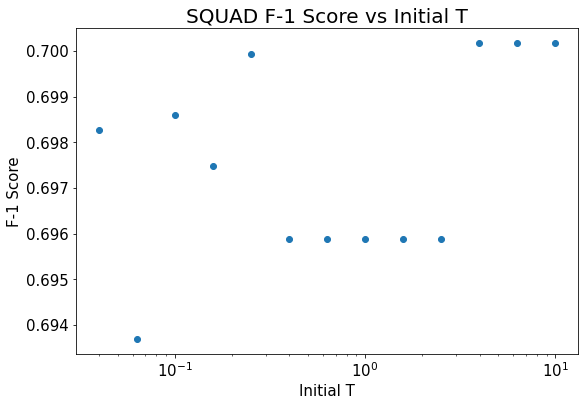

In [87]:
fig, ax = plt.subplots(figsize = (9,6))
ax.scatter(x, y)
ax.set_xscale("log")
ax.set_title("SQUAD F-1 Score vs Initial T", fontsize=20)
ax.set_xlabel("Initial T", fontsize=15)
ax.set_ylabel("F-1 Score", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [49]:
eval(0.1)

100%|██████████| 11858/11858 [01:11<00:00, 165.54it/s]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.54493587638033

In [38]:
#SYNTHESIS DPR
y_pred = []
y_label = []
batch_conf = []
batch_acc = []
increments = 10
bins = {i/increments: {"confs": [], "acc": 0} for i in range(1, increments+1)}
temp = 1
step = 0.01
print(rows)
for i in tqdm(range(len(rows))):
    c_embeds = []
    q_embeds = []
    preds = []
    for d in range(len(phrase_lens)):
        query, context, ixs, label = datasets[d][i]
        c_embeds.append(context)
        q_embeds.append(query)
    pred = syn_DPR(phrase_lens, q_embeds, c_embeds, ixs, temp)
    for j in range(len(pred)):
        print(j+1, pred[j])
    # update_bins(bins, [pred], [conf], increments, label)
    # y_pred.append(int(pred))
    # y_label.append(int(label))
    # if i%int(len(rows)/10)== 0 and i != 0:
    #     loss, grad = calc_bin_loss(bins)
    #     temp += float(step*grad)
    #     bins = {i/increments: {"confs": [], "acc": 0} for i in range(1, increments+1)}
    #     print(i, loss)
# print("FINAL TEMP:", temp)
# print(classification_report(y_label, y_pred, digits=4))


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]


100%|██████████| 1/1 [00:00<00:00, 21.06it/s]

1 65
2 16
3 47
4 10
5 20
6 5
7 29
8 27
9 72
10 46
11 85
12 0
13 79
14 58
15 90
16 4
17 23
18 83
19 68
20 25
21 21
22 33
23 99
24 37
25 81
26 7
27 62
28 11
29 32
30 71
31 9
32 14
33 53
34 28
35 66
36 74
37 60
38 30
39 51
40 63
41 49
42 75
43 39
44 42
45 56
46 18
47 36
48 52
49 40
50 13
51 96
52 8
53 91
54 82
55 87
56 84
57 43
58 55
59 86
60 95
61 35
62 6
63 22
64 15
65 54
66 24
67 94
68 73
69 57
70 31
71 93
72 70
73 1
74 77
75 69
76 34
77 3
78 78
79 76
80 50
81 26
82 41
83 67
84 48
85 64
86 17
87 2
88 98
89 38
90 89
91 97
92 44
93 88
94 12
95 92
96 61
97 80
98 45
99 19
100 59


In [78]:
print(len(datasets[2].context_embeds))

100
